# IAI5101 Assignment 1

_Studying factors influencing the probability of patients' attendance to their scheduled appointments at the Houston Bay Clinic_

By Simon Tremblay, 8213373

This code was written to run with:
- Python v3.10
- Scikit Learn v1.0.2
- Numpy v1.22.1
- MatplotLib v3.5.1
- Category Encoders v2.3.0
- Seaborn v0.11.2
- Calplot v0.1.7.3

In [41]:
# Imports of frequently changing packages
import sys
import sklearn
import numpy as np
import seaborn as sn
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import category_encoders as ce
import calplot

print("Running:")
print("- Python v" + str(sys.version_info[0]) + "." + str(sys.version_info[2]))
print("- Scikit Learn v" + sklearn.__version__)
print("- Seaborn v" + sn.__version__)
print("- Numpy v" + np.__version__)
print("- Matplot Lib v" + matplotlib.__version__)
print("- Category Encoders v" + ce.__version__)
print("- Calplot v" + calplot.__version__)

Running:
- Python v3.2
- Scikit Learn v1.0.2
- Seaborn v0.11.2
- Numpy v1.22.1
- Matplot Lib v3.5.1
- Category Encoders v2.3.0
- Calplot v0.1.7.3


## Introduction
This assignment will cover Feature Engineering, Model Development, and Model Evaluation and Comparisons as it pertains to the training of a machine learning algorithm (specifically, one built upon a Naive Bayes Model) to predict if a patient scheduled for an appointement will indeed make it to their appointment or not. The data available for the predictions are as follows:
- Patient Age
- Patient Gender
- Patient Appointment Date
- Patients' Diseases

## Feature Engineering
This section will cover feature engineering steps.

### Reading the Data
We first read the raw data. To speed things up if ever we have to re-run the code, we'll dump it back to a CSV and use that in the future.

In [42]:
import os.path

# Read the data (csv if available, xlsx otherwise)
if os.path.isfile('./MedicalCentre.csv'):
    bay_clinic_data = pd.read_csv('./MedicalCentre.csv')
else:
    bay_clinic_data = pd.read_excel('./MedicalCentre.xlsx')
    # Create a .csv so it's (MUCH) faster to re-load the data in the future
    bay_clinic_data.to_csv('./MedicalCentre.csv', index = False)

bay_clinic_data['PatientId'] = bay_clinic_data['PatientId'].astype(str)
bay_clinic_data

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296.0,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438.0,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951.0,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174.0,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183.0,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2572134369293.0,5651768,F,2016-05-03T09:15:35Z,2016-06-07T00:00:00Z,56,MARIA ORTIZ,0,0,0,0,0,1,No
110523,3596266328735.0,5650093,F,2016-05-03T07:27:33Z,2016-06-07T00:00:00Z,51,MARIA ORTIZ,0,0,0,0,0,1,No
110524,15576631729893.0,5630692,F,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,92134931435557.0,5630323,F,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,1,No


### Data Preparation

#### Assumptions

The following (trivial) assumption is made about the data:

1. The Appointment ID has no effect on the probability of a patient showing up to their appointment.

Thus, this column is completely dropped from the set.

In [43]:
# Drop the patient ID and appointment ID
data_noID = bay_clinic_data.drop(['AppointmentID'], axis=1)
data_noID

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296.0,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438.0,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951.0,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174.0,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183.0,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2572134369293.0,F,2016-05-03T09:15:35Z,2016-06-07T00:00:00Z,56,MARIA ORTIZ,0,0,0,0,0,1,No
110523,3596266328735.0,F,2016-05-03T07:27:33Z,2016-06-07T00:00:00Z,51,MARIA ORTIZ,0,0,0,0,0,1,No
110524,15576631729893.0,F,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,92134931435557.0,F,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,1,No


#### Missing or Improper Values

Where values are missing (Not a Number) or improper, these are to be dropped.

The Scheduled Day columns is problematic in that it contains date _and_ time data and is unsuitable for comparisons with appointment day (which is only entered as a day). The time data will therefore be split out into a new column, the seconds information removed, and the time converted to minutes from midnight (Houston timezone) to see if the time of day at which an appointment was scheduled has any effect on patients showing up to their appointments. Appointment Day, which contains no time data, will have the time data stripped out so that solely day information remains.

In [44]:
# Drop missing
data_noID.dropna(inplace = True)

# Drop negative ages, but first change
# the datatype for Age to unsigned integers
print("There are " + str(len(data_noID[data_noID['Age'] < 0].index)) + " entries with negative ages. They will be dropped.")
data_noID.drop(data_noID[data_noID['Age'] < 0].index, inplace=True)

# Imports for datetime manipulations
from datetime import datetime, timedelta

# Define lambda to round up time to the nearest minute
def roundMinutes(x):
    if x.second >= 30:
        x = x + timedelta(minutes = 1)
    x = x - timedelta(seconds = x.second)
    return x

# Define a lambda to convert timezone data, taking
# into account historical daylight savings time
# Source: https://www.timeanddate.com/time/change/usa/houston
def tz_DST_conv(x):
    match x.year:
        case 2015: # 2015 DST from March 8th to November 1st
            if (x.month > 3 and x.month < 11) or (x.month == 3 and x.day >= 8):
                x = x.tz_convert(tz='Etc/GMT+5')
        case 2016: # 2016 DST from March 13 to November 6
            if (x.month > 3 and x.month < 11) or (x.month == 3 and x.day >= 13) or (x.month == 11 and x.day < 6):
                x = x.tz_convert(tz='Etc/GMT+5')
        case 2017: # 2017 DST from March 12 to November 5
            if (x.month > 3 and x.month < 11) or (x.month == 3 and x.day >= 12) or (x.month == 11 and x.day < 5):
                x = x.tz_convert(tz='Etc/GMT+5')
        case _: x = x.tz_convert(tz='Etc/GMT+6')
    return x.time()

# Create a new temporary DataFrame
tempDF = pd.concat([data_noID['ScheduledDay'], data_noID['AppointmentDay']], axis=1)
tempDF.applymap(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ'))
tempDF['ScheduledDay'] = pd.to_datetime(tempDF['ScheduledDay'])
tempDF['AppointmentDay'] = pd.to_datetime(tempDF['AppointmentDay'])
tempDF['ScheduledDay'] = tempDF['ScheduledDay'].map(lambda x: roundMinutes(x))

# Convert to Houston timezone (respective of daylight savings)
tempDF['TimeOfScheduling_Houston'] = tempDF['ScheduledDay'].map(lambda x: tz_DST_conv(x))

# Remove date info from time column and time info from date columns
tempDF['ScheduledDay'] = pd.to_datetime(tempDF['ScheduledDay']).dt.date
tempDF['AppointmentDay'] = tempDF['AppointmentDay'].dt.date

# Move the new columns to the original DataFrame
data_noID['ScheduledDay'] = tempDF['ScheduledDay']
data_noID['AppointmentDay'] = tempDF['AppointmentDay']
data_noID = pd.concat([data_noID[data_noID.columns[:2]], tempDF['TimeOfScheduling_Houston'], data_noID[data_noID.columns[2:]]], axis=1)
data_noID

There are 1 entries with negative ages. They will be dropped.


,PatientId,Gender,TimeOfScheduling_Houston,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296.0,F,13:38:00,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438.0,M,11:08:00,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951.0,F,11:19:00,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174.0,F,12:30:00,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183.0,F,11:07:00,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2572134369293.0,F,04:16:00,2016-05-03,2016-06-07,56,MARIA ORTIZ,0,0,0,0,0,1,No
110523,3596266328735.0,F,02:28:00,2016-05-03,2016-06-07,51,MARIA ORTIZ,0,0,0,0,0,1,No
110524,15576631729893.0,F,11:04:00,2016-04-27,2016-06-07,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,92134931435557.0,F,10:09:00,2016-04-27,2016-06-07,38,MARIA ORTIZ,0,0,0,0,0,1,No


#### Time to Appointment

In this block of code, a column is added for the number of days between scheduling and appointment.

In [45]:
tempDF = data_noID
tempDF['DaysToAppnt'] = (tempDF['AppointmentDay'] - tempDF['ScheduledDay']).dt.days
data_noID = pd.concat([tempDF[tempDF.columns[:4]], tempDF['DaysToAppnt'], tempDF[tempDF.columns[4:14]]], axis=1)
data_noID

,PatientId,Gender,TimeOfScheduling_Houston,ScheduledDay,DaysToAppnt,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296.0,F,13:38:00,2016-04-29,0,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438.0,M,11:08:00,2016-04-29,0,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951.0,F,11:19:00,2016-04-29,0,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174.0,F,12:30:00,2016-04-29,0,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183.0,F,11:07:00,2016-04-29,0,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2572134369293.0,F,04:16:00,2016-05-03,35,2016-06-07,56,MARIA ORTIZ,0,0,0,0,0,1,No
110523,3596266328735.0,F,02:28:00,2016-05-03,35,2016-06-07,51,MARIA ORTIZ,0,0,0,0,0,1,No
110524,15576631729893.0,F,11:04:00,2016-04-27,41,2016-06-07,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,92134931435557.0,F,10:09:00,2016-04-27,41,2016-06-07,38,MARIA ORTIZ,0,0,0,0,0,1,No


#### No-Show (Show) Data

The no-show data will be converted from yes/no to integers (0 or 1) same as the other columns. The name of the column (and the sense of the data) will be changed to a positive value (i.e.: no-show is changed to showed) to avoid double-negatives and confusion in understanding the data.

In [46]:
# Replace the no-show No/Yes to binary 1/0 and replace to positive
# column name to avoid double negatives (less confusing)
try:
    data_noID['No-show'] = data_noID['No-show'].replace("No", 1)
    data_noID['No-show'] = data_noID['No-show'].replace("Yes", 0)
    data_noID = data_noID.rename(columns={'No-show': 'Showed'})
except: pass

data_noID

,PatientId,Gender,TimeOfScheduling_Houston,ScheduledDay,DaysToAppnt,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Showed
0,29872499824296.0,F,13:38:00,2016-04-29,0,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,1
1,558997776694438.0,M,11:08:00,2016-04-29,0,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,1
2,4262962299951.0,F,11:19:00,2016-04-29,0,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,1
3,867951213174.0,F,12:30:00,2016-04-29,0,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1
4,8841186448183.0,F,11:07:00,2016-04-29,0,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2572134369293.0,F,04:16:00,2016-05-03,35,2016-06-07,56,MARIA ORTIZ,0,0,0,0,0,1,1
110523,3596266328735.0,F,02:28:00,2016-05-03,35,2016-06-07,51,MARIA ORTIZ,0,0,0,0,0,1,1
110524,15576631729893.0,F,11:04:00,2016-04-27,41,2016-06-07,21,MARIA ORTIZ,0,0,0,0,0,1,1
110525,92134931435557.0,F,10:09:00,2016-04-27,41,2016-06-07,38,MARIA ORTIZ,0,0,0,0,0,1,1


### Feature Frequencies and Data Visualization

This section will study the frequency of distinct features in each feature set. This is done using the value_counts() function from the Pandas package and other plotting tools. This section also serves as a means to visualize the data found in the dataset.

#### Binary Encodable Values

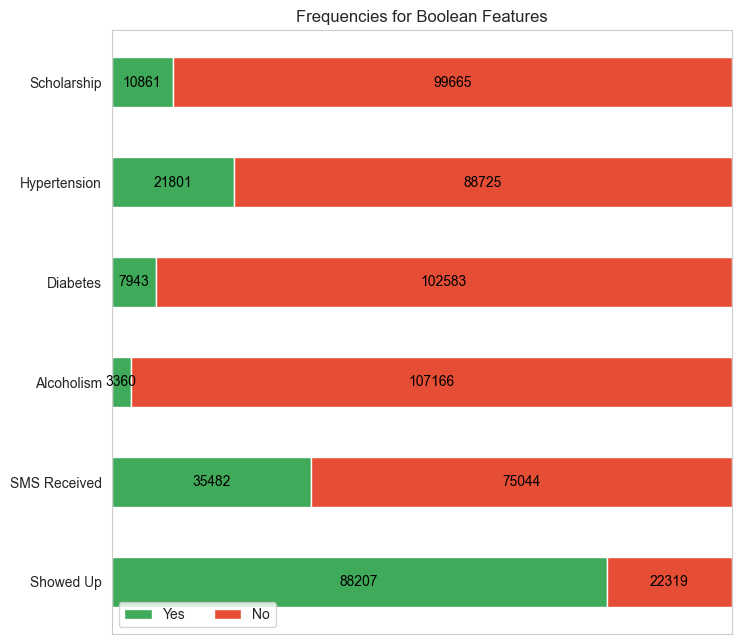

In [47]:
category_names = ['Yes','No']
results = {
    'Scholarship' : data_noID['Scholarship'].sort_values(ascending=False).value_counts(sort=False),
    'Hypertension' : data_noID['Hipertension'].sort_values(ascending=False).value_counts(sort=False),
    'Diabetes' : data_noID['Diabetes'].sort_values(ascending=False).value_counts(sort=False),
    'Alcoholism' : data_noID['Alcoholism'].sort_values(ascending=False).value_counts(sort=False),
    'SMS Received' : data_noID['SMS_received'].sort_values(ascending=False).value_counts(sort=False),
    'Showed Up' : data_noID['Showed'].sort_values(ascending=False).value_counts(sort=False),
    }

def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['RdYlGn'](
        np.linspace(0.85, 0.15, data.shape[1]))

    fig, ax = plt.subplots(figsize=(8, 8), dpi = 100)
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'black'
        ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 0),
              loc='lower left', fontsize='medium')
    return fig, ax


survey(results, category_names)
plt.title('Frequencies for Boolean Features')
plt.show()

#### Gender Distribution

In [48]:
# M/F distribution
genderDF = pd.DataFrame(data_noID['Gender'].value_counts())['Gender'].to_dict()
for key in genderDF:
    print(str(key) + ": " + str(genderDF[key]) + " (" + str(round(genderDF[key]/sum(genderDF.values())*1000)/10) + "%)")

F: 71839 (65.0%)
M: 38687 (35.0%)


#### Age Distribution & Outlier Detection

Age distribution frequencies are plotted using a histogram. Outliers are detected by plotting the box plot of ages. Age frequencies are then given.

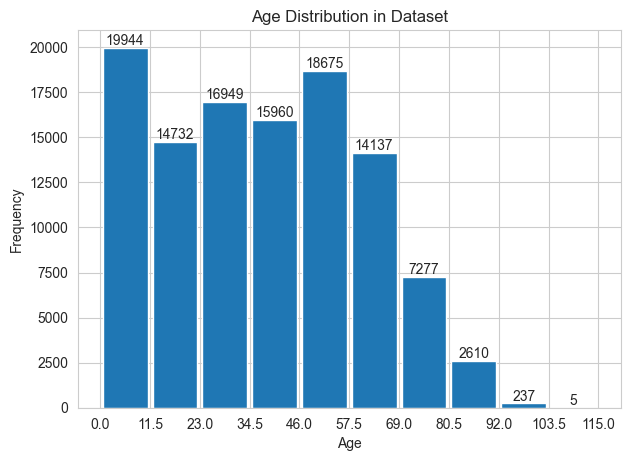

In [49]:
# Using a histogram
fig, ageHist = plt.subplots(1, 1, figsize=(7,5), dpi=100)

vals, bins, edges = ageHist.hist(data_noID['Age'], rwidth=0.9)
ageHist.set_xticks(bins)
ageHist.set_title("Age Distribution in Dataset")
ageHist.set_xlabel('Age')
ageHist.set_ylabel('Frequency')

rects = ageHist.patches
labels = vals.astype(int)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ageHist.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom')

The percentiles (1, 25, 50, 75 and 99th) for Age are as follows:
[ 0. 18. 37. 55. 86.], respectively.
The interquartile range (IQr) is: 37.0, the maximum (Q3 + 1.5IQr) is 110.5


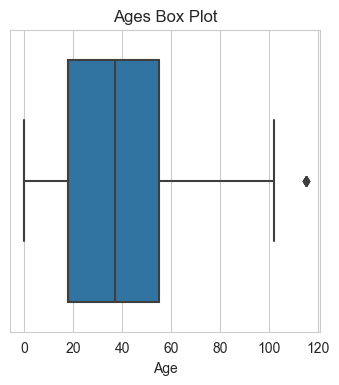

In [50]:
# Create a box plot of ages to detect outliers
plt.figure(figsize=(4,4), dpi=100)
plt.title('Ages Box Plot')
sn.set_style(style='whitegrid')

print('The percentiles (1, 25, 50, 75 and 99th) for Age are as follows:')
print(str(np.percentile(data_noID['Age'], [1,25,50,75,99])) + ", respectively.")
IQr = np.percentile(data_noID['Age'], 75) - np.percentile(data_noID['Age'], 25)
cutoff = np.percentile(data_noID['Age'], 75) + 1.5*IQr
print("The interquartile range (IQr) is: " + str(IQr) + ", the maximum (Q3 + 1.5IQr) is " + str(cutoff))
sn.boxplot(x=data_noID['Age'],data=data_noID)
plt.show()

In [51]:
print("Values outside of the Q3 + 1.5IQr are dropped for the dataset. " + str(len(data_noID[data_noID['Age'] > cutoff].index)) + " values were found outside of the cutoff range.")
data_noID.drop(data_noID[data_noID['Age'] > cutoff].index, inplace=True)

Values outside of the Q3 + 1.5IQr are dropped for the dataset. 5 values were found outside of the cutoff range.


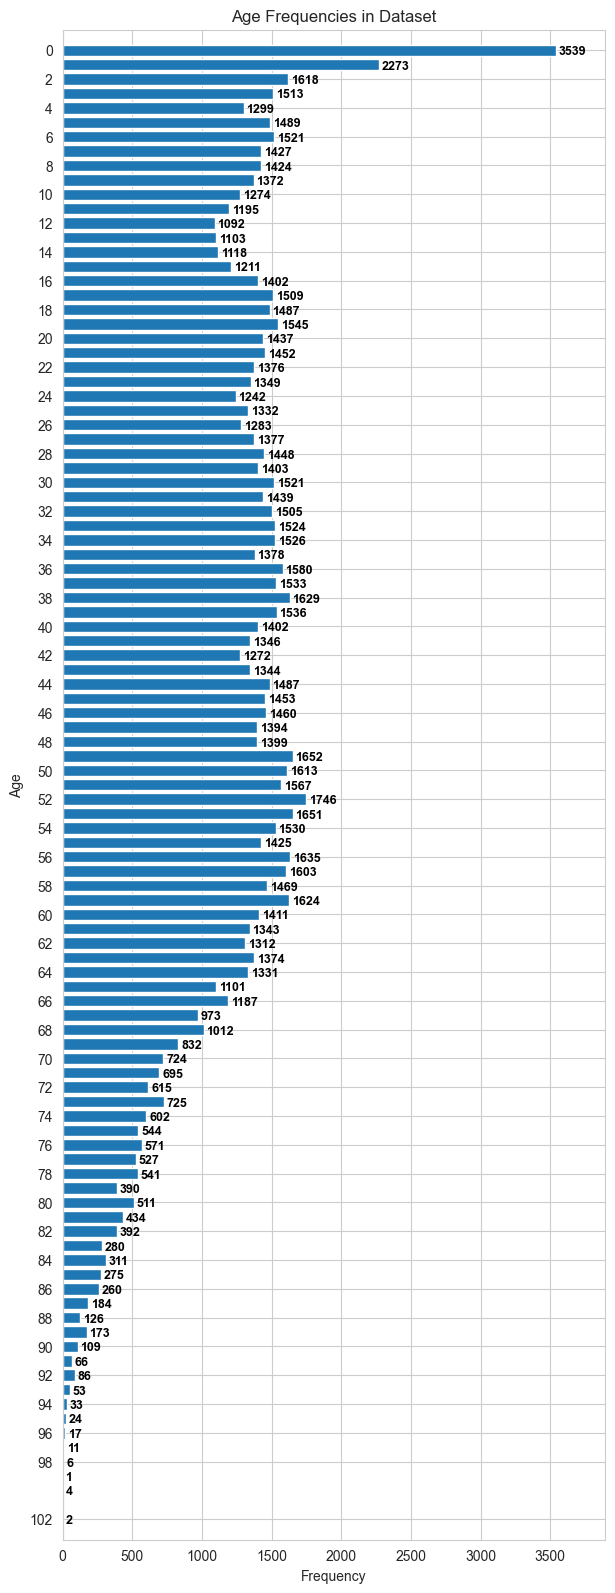

In [52]:
# Age frequencies given as a horizontal bar plot
fig, ages = plt.subplots(1, 1, figsize=(7,20), dpi=100)

# Fetch the data by sorting
ages_sorted = np.sort(data_noID['Age'].unique())
freqs = data_noID['Age'].sort_values().value_counts(sort=False)

# Make the plot
ages.barh(ages_sorted, freqs.values)
ages.set_title('Age Frequencies in Dataset')
ages.set_xlabel('Frequency')
ages.set_ylabel('Age')
yticks = np.array(range(0, max(ages_sorted),2))
yticks = np.concatenate((yticks[:-1], [max(ages_sorted)]))
ages.set_yticks(yticks)
ages.invert_yaxis()

# Add annotation to bars
for i in ages.patches:
    plt.text(i.get_width()+20, i.get_y()+0.7,
             str(round((i.get_width()), 2)),
             fontsize=9, fontweight='bold',
             color='black')

ages.margins(x=0.1,y=0.01)

#### Neighbourhoods

Neighbourhood data is also plotted on a horizontal bar plot.

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 141 (\x8d) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


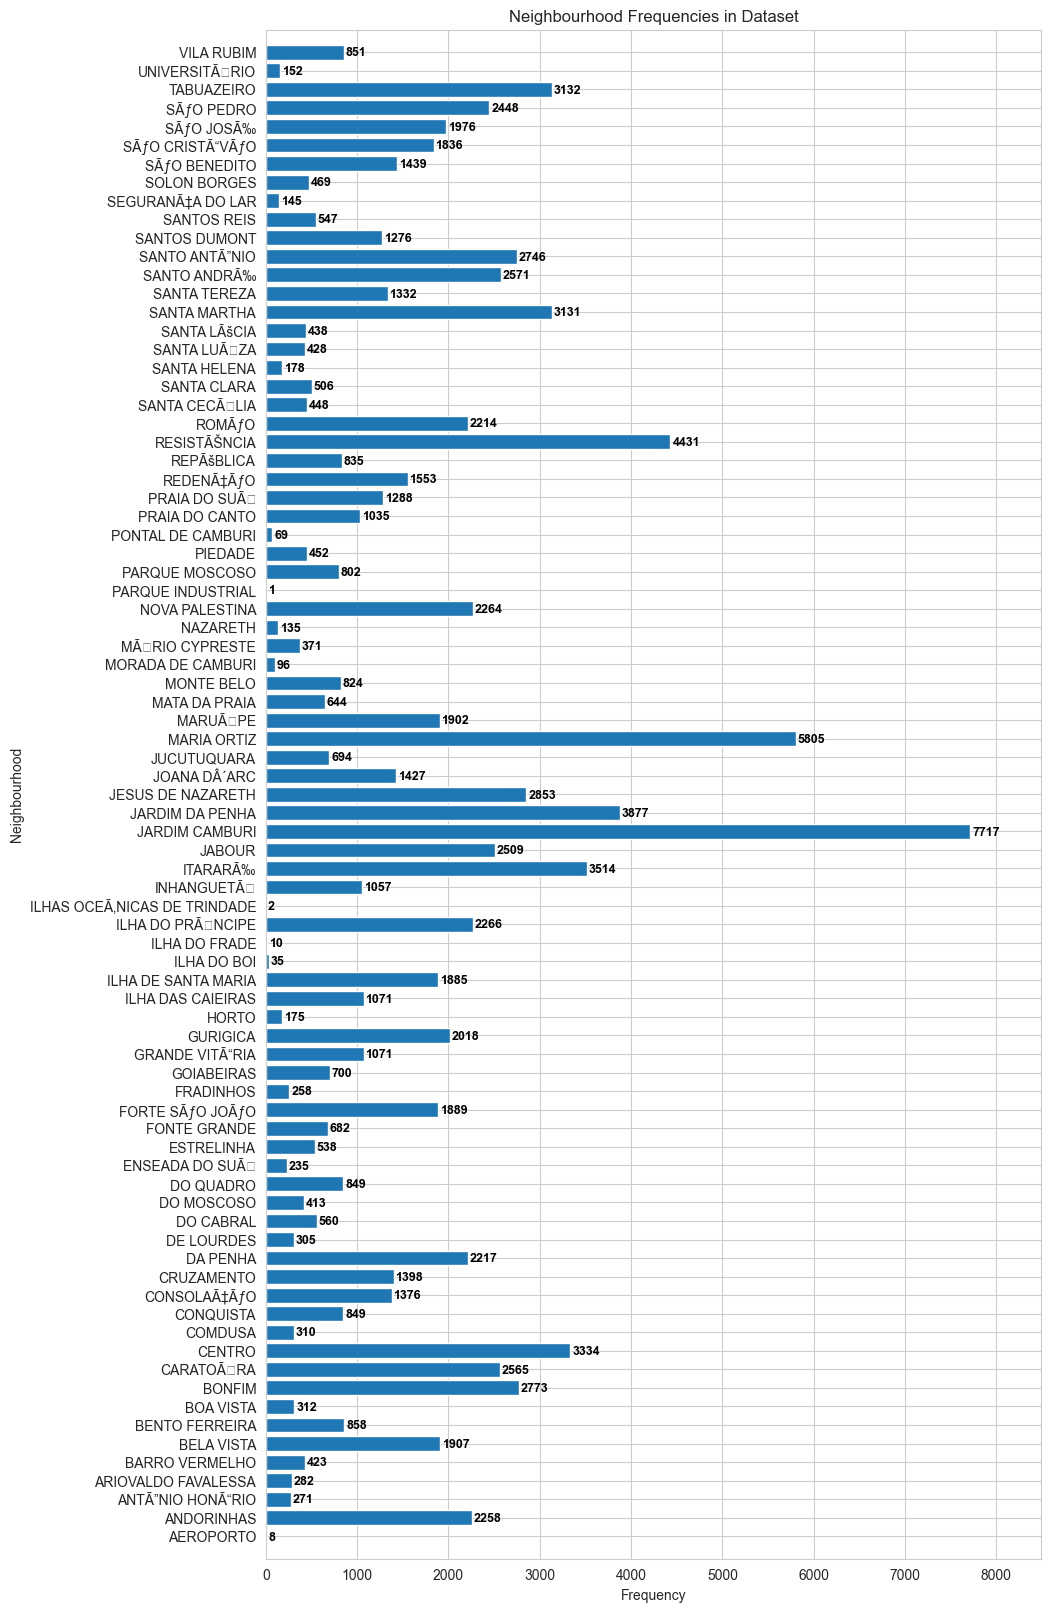

In [53]:
# Neighbourhood frequencies given as a horizontal bar plot
# Fetch sorted data
neighbourhoods_sorted = np.sort(data_noID['Neighbourhood'].unique())
freqs = data_noID['Neighbourhood'].sort_values().value_counts(sort=False)

# Create the plot object
fig, neighb = plt.subplots(1, 1, figsize=(10,0.25*len(freqs)), dpi=100)

# Make the plot
neighb.barh(neighbourhoods_sorted, freqs.values)
neighb.set_title('Neighbourhood Frequencies in Dataset')
neighb.set_xlabel('Frequency')
neighb.set_ylabel('Neighbourhood')

# Add annotation to bars
for i in neighb.patches:
    plt.text(i.get_width()+20, i.get_y()+len(freqs)*.0025,
             str(round((i.get_width()), 2)),
             fontsize=9, fontweight='bold',
             color='black')

neighb.margins(x=0.1,y=0.01)


#### Patient ID

In [54]:
print("There are " + str(len(data_noID['PatientId'].unique())) + " unique patient IDs.")

There are 62296 unique patient IDs.


### Data Encoding

This section copies over the dataframe. The Scheduled and Appointment date columns are removed and the days to appointment is z-normalized. 

In [55]:
# Use copy constructor to make the encoded dataframe
data_Encoded = pd.DataFrame(data_noID)
data_Encoded.drop('ScheduledDay', axis=1, inplace=True)
data_Encoded.drop('AppointmentDay', axis=1, inplace=True)
data_Encoded['DaysToAppnt'] = (data_noID['DaysToAppnt'] - data_noID['DaysToAppnt'].mean())/data_noID['DaysToAppnt'].std(ddof=0)

#### Gender

Gender data will be changed to 0 for Male and 1 for Female.

In [56]:
def genderEncode(gender):
    if 'M' in gender: return 0
    if 'F' in gender: return 1

# Replace Male to 0s and Female to 1s
try:
    data_Encoded['Gender'] = data_noID['Gender'].apply(lambda gender: genderEncode(gender))
except: pass

data_Encoded

,PatientId,Gender,TimeOfScheduling_Houston,DaysToAppnt,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Showed
0,29872499824296.0,1,13:38:00,-0.667566,62,JARDIM DA PENHA,0,1,0,0,0,0,1
1,558997776694438.0,0,11:08:00,-0.667566,56,JARDIM DA PENHA,0,0,0,0,0,0,1
2,4262962299951.0,1,11:19:00,-0.667566,62,MATA DA PRAIA,0,0,0,0,0,0,1
3,867951213174.0,1,12:30:00,-0.667566,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1
4,8841186448183.0,1,11:07:00,-0.667566,56,JARDIM DA PENHA,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2572134369293.0,1,04:16:00,1.626762,56,MARIA ORTIZ,0,0,0,0,0,1,1
110523,3596266328735.0,1,02:28:00,1.626762,51,MARIA ORTIZ,0,0,0,0,0,1,1
110524,15576631729893.0,1,11:04:00,2.020076,21,MARIA ORTIZ,0,0,0,0,0,1,1
110525,92134931435557.0,1,10:09:00,2.020076,38,MARIA ORTIZ,0,0,0,0,0,1,1


#### Age

The age is standardized using Z-Score Standardization.

In [57]:
data_Encoded['Age'] = (data_noID['Age'] - data_noID['Age'].mean())/data_noID['Age'].std(ddof=0)

data_Encoded

,PatientId,Gender,TimeOfScheduling_Houston,DaysToAppnt,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Showed
0,29872499824296.0,1,13:38:00,-0.667566,1.078331,JARDIM DA PENHA,0,1,0,0,0,0,1
1,558997776694438.0,0,11:08:00,-0.667566,0.818642,JARDIM DA PENHA,0,0,0,0,0,0,1
2,4262962299951.0,1,11:19:00,-0.667566,1.078331,MATA DA PRAIA,0,0,0,0,0,0,1
3,867951213174.0,1,12:30:00,-0.667566,-1.258876,PONTAL DE CAMBURI,0,0,0,0,0,0,1
4,8841186448183.0,1,11:07:00,-0.667566,0.818642,JARDIM DA PENHA,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2572134369293.0,1,04:16:00,1.626762,0.818642,MARIA ORTIZ,0,0,0,0,0,1,1
110523,3596266328735.0,1,02:28:00,1.626762,0.602234,MARIA ORTIZ,0,0,0,0,0,1,1
110524,15576631729893.0,1,11:04:00,2.020076,-0.696215,MARIA ORTIZ,0,0,0,0,0,1,1
110525,92134931435557.0,1,10:09:00,2.020076,0.039573,MARIA ORTIZ,0,0,0,0,0,1,1


#### Time of Scheduling

The time of scheduling is changed to minutes from midnight and linearly normalized between 0 and 1 (whereas cyclical normalization might've been an option here, it would simply add a dimension to the model without providing insight to the hypothesis that time of day has an effect on the test).

In [58]:
minutesPerDay = 24*60

# Switch to minutes from midnight representation for time of scheduling and normalize
data_Encoded['TimeOfScheduling_Houston'] = data_noID['TimeOfScheduling_Houston'].apply(lambda x: int(x.hour*60 + x.minute) / minutesPerDay)

data_Encoded

,PatientId,Gender,TimeOfScheduling_Houston,DaysToAppnt,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Showed
0,29872499824296.0,1,0.568056,-0.667566,1.078331,JARDIM DA PENHA,0,1,0,0,0,0,1
1,558997776694438.0,0,0.463889,-0.667566,0.818642,JARDIM DA PENHA,0,0,0,0,0,0,1
2,4262962299951.0,1,0.471528,-0.667566,1.078331,MATA DA PRAIA,0,0,0,0,0,0,1
3,867951213174.0,1,0.520833,-0.667566,-1.258876,PONTAL DE CAMBURI,0,0,0,0,0,0,1
4,8841186448183.0,1,0.463194,-0.667566,0.818642,JARDIM DA PENHA,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2572134369293.0,1,0.177778,1.626762,0.818642,MARIA ORTIZ,0,0,0,0,0,1,1
110523,3596266328735.0,1,0.102778,1.626762,0.602234,MARIA ORTIZ,0,0,0,0,0,1,1
110524,15576631729893.0,1,0.461111,2.020076,-0.696215,MARIA ORTIZ,0,0,0,0,0,1,1
110525,92134931435557.0,1,0.422917,2.020076,0.039573,MARIA ORTIZ,0,0,0,0,0,1,1


#### Patient ID

Patient IDs are factorized.

In [60]:
data_Encoded['PatientId'] = pd.factorize(data_Encoded['PatientId'])[0]
data_Encoded['PatientId'] = (data_Encoded['PatientId'] - data_Encoded['PatientId'].min()) / (data_Encoded['PatientId'].max() - data_Encoded['PatientId'].min())
data_Encoded

,PatientId,Gender,TimeOfScheduling_Houston,DaysToAppnt,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Showed
0,0.000000,1,0.568056,-0.667566,1.078331,JARDIM DA PENHA,0,1,0,0,0,0,1
1,0.000016,0,0.463889,-0.667566,0.818642,JARDIM DA PENHA,0,0,0,0,0,0,1
2,0.000032,1,0.471528,-0.667566,1.078331,MATA DA PRAIA,0,0,0,0,0,0,1
3,0.000048,1,0.520833,-0.667566,-1.258876,PONTAL DE CAMBURI,0,0,0,0,0,0,1
4,0.000064,1,0.463194,-0.667566,0.818642,JARDIM DA PENHA,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,0.737587,1,0.177778,1.626762,0.818642,MARIA ORTIZ,0,0,0,0,0,1,1
110523,0.014062,1,0.102778,1.626762,0.602234,MARIA ORTIZ,0,0,0,0,0,1,1
110524,1.000000,1,0.461111,2.020076,-0.696215,MARIA ORTIZ,0,0,0,0,0,1,1
110525,0.738663,1,0.422917,2.020076,0.039573,MARIA ORTIZ,0,0,0,0,0,1,1


#### Neighbourhood Data

Neighbourhood data is encoded using one hot encoding.

In [61]:
# Create the encoder object and drop the neighbourhood column from the original dataframe.
neighbOHEncoder = ce.OneHotEncoder(cols=['Neighbourhood'])
data_OHE_Encoded = neighbOHEncoder.fit_transform(data_Encoded)
data_Encoded.drop('Neighbourhood', axis=1, inplace=True)
data_OHE_Encoded

,PatientId,Gender,TimeOfScheduling_Houston,DaysToAppnt,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,...,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Showed
0,0.000000,1,0.568056,-0.667566,1.078331,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0.000016,0,0.463889,-0.667566,0.818642,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.000032,1,0.471528,-0.667566,1.078331,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.000048,1,0.520833,-0.667566,-1.258876,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.000064,1,0.463194,-0.667566,0.818642,1,0,0,0,0,...,0,0,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,0.737587,1,0.177778,1.626762,0.818642,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
110523,0.014062,1,0.102778,1.626762,0.602234,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
110524,1.000000,1,0.461111,2.020076,-0.696215,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
110525,0.738663,1,0.422917,2.020076,0.039573,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


### Correlated Features

Correlated features are finally detected and dropped. Neighbourhood OHEncoded values are not included in this check.

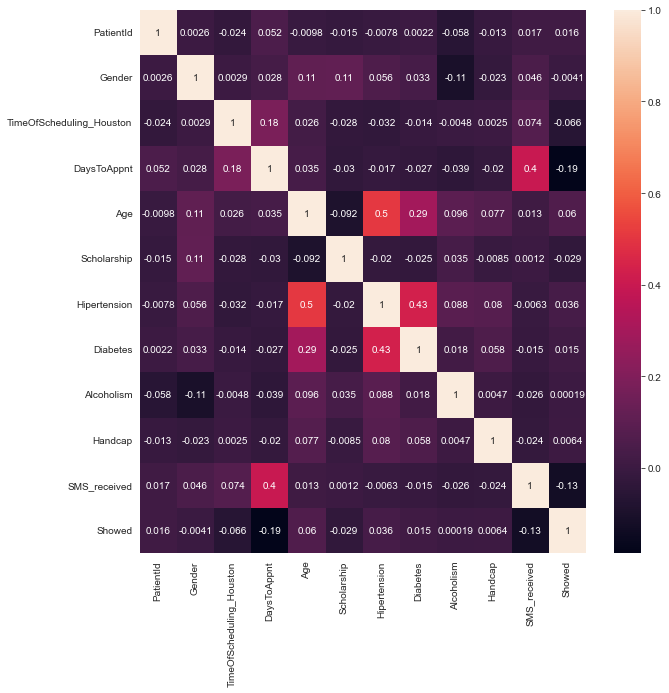

In [62]:
# Generate and plot the correlation matrix
fig, htmp = plt.subplots(figsize=(10,10))

corrMatrix = data_Encoded.corr()
sn.heatmap(corrMatrix, annot=True, ax=htmp)
plt.show()

Given that hypertension and age as well as hypertension and diabetes show some correlation, hypertension is dropped from the set. Since the days to appointment and SMS received are also somewhat correlated (understandbly so, if the clinic implemented a notifications system that in only in effect if the appointment is scheduled more than a day in advance). SMS_received is therefore also dropped from the set.

In [63]:
try:
    data_Encoded.drop('Hipertension', axis=1, inplace=True)
    data_Encoded.drop('SMS_received', axis=1, inplace=True)
except: pass

try:
    data_OHE_Encoded.drop('Hipertension', axis=1, inplace=True)
    data_OHE_Encoded.drop('SMS_received', axis=1, inplace=True)
except: pass

## Naive Bayes Model

A Naive Bayes model is initially tested to see how well a patient's attendance may be predicted. The training dataset will contain 70% of the available data, and the rest of the 30% will be used for testing. Since neighbourhood data is One Hot Encoded, a Multivariate Bernoulli Naive Bayes model is used.

In [64]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score

data_loaded = data_OHE_Encoded
features = data_loaded[data_loaded.columns[:-1]]
label = data_loaded['Showed']

#Splitting the dataset into training and testing variables
feat_train, feat_test, label_train, label_test = train_test_split(features, label, test_size=0.3, random_state=20)

#Calling the Class
naive_bayes = BernoulliNB()

#Fitting the data to the classifier
naive_bayes.fit(feat_train, label_train)
 
#Predict on test data
y_predicted = naive_bayes.predict(feat_test)

# Test the predicted outcomes against the test set
print("Through simple evaluation of the model against a test set (30% of the dataset), we find the Bernoulli Naive Bayes Model to be " + str(round(1000*metrics.accuracy_score(y_predicted , label_test))/10) + "% accurate.")

Through simple evaluation of the model against a test set (30% of the dataset), we find the Bernoulli Naive Bayes Model to be 79.7% accurate.


## Model Evaluation

This section will serve to the evaluation of the Bernoulli Naive Bayes model.

### Overfitting Detection using K-Fold

The model is evaluated using repeated stratified k-fold cross-validation to make sure no overfitting occured.

In [65]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

n_splits = 20
n_repeats = 4
random_state = 20

kfold_cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
results = cross_val_score(naive_bayes, features, label, cv=kfold_cv)
print("Training using " + str(n_splits) + " splits and " + str(n_repeats) + " repeats gave a mean of " + str(round(np.mean(results)*1000)/10) + "% accuracy, with a stdev of " + str(round(1000*np.std(results))/10) + "%.")
print("The max accuracy was " + str(round(np.max(results)*1000)/10) + "% and the minimum " + str(round(np.min(results)*1000)/10) + "%.")

Training using 20 splits and 4 repeats gave a mean of 79.8% accuracy, with a stdev of 0.0%.
The max accuracy was 79.9% and the minimum 79.7%.


From the results, it is safe to say that there was no over-fitting.

### Model Tuning (Open CV)

The next section will deal with tuning of the model using OpenCV.

In [66]:
from sklearn.model_selection import GridSearchCV

param_grid_nb = { 'alpha' : [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 10.0] }

nbModel_grid = GridSearchCV(estimator=naive_bayes, param_grid=param_grid_nb, verbose=1, cv=20, n_jobs=-1)

best_model = nbModel_grid.fit(feat_train, label_train)

Fitting 20 folds for each of 7 candidates, totalling 140 fits


Train Accuracy : 0.799
Test Accuracy : 0.797
Best Accuracy Through Grid Search : 0.799
Best Parameters :  {'alpha': 2.0}

Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.00      0.00      6739
           1       0.80      1.00      0.89     26418

    accuracy                           0.80     33157
   macro avg       0.56      0.50      0.44     33157
weighted avg       0.70      0.80      0.71     33157


 F1:
 0.8867059593975115

 Precision score is:
 0.796831145314622

 Recall score is:
 0.9994322053145582

 Confusion Matrix:



<AxesSubplot:>

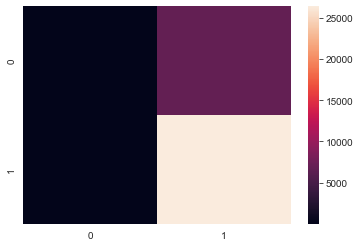

In [67]:
nb_pred = best_model.predict(feat_test)

print('Train Accuracy : %.3f'%nbModel_grid.best_estimator_.score(feat_train, label_train))
print('Test Accuracy : %.3f'%nbModel_grid.best_estimator_.score(feat_test, label_test))
print('Best Accuracy Through Grid Search : %.3f'%nbModel_grid.best_score_)
print('Best Parameters : ',nbModel_grid.best_params_)
print()
print("Classification Report:\n", classification_report(label_test, nb_pred))
print("\n F1:\n", f1_score(label_test, nb_pred))
print("\n Precision score is:\n", precision_score(label_test, nb_pred))
print("\n Recall score is:\n", recall_score(label_test, nb_pred))
print("\n Confusion Matrix:\n")

sn.heatmap(confusion_matrix(label_test, nb_pred))

From the classification report, it can be seen that this model is not very precise in knowing if a patient will not show up to their appointment.

### SVM and Decision Tree

SVM and Decision Tree models will here be implemented to compare to the Bernoulli Naive Bayes model.

#### SVM

In [97]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score

# Do not use the neighbourhood data as it does not contribute to the model
# and the OHE neighbourhoods makes the training inherently slow.
data_loaded = data_Encoded
features = data_loaded[data_loaded.columns[:-1]]
label = data_loaded['Showed']

#Splitting the dataset into training and testing variables
feat_train, feat_test, label_train, label_test = train_test_split(features, label, test_size=0.3, random_state=20)

model = SVC()
kernel = ['poly'] # Determined experimentally as best
C = [0.01, 0.1, 0.5]
gamma = ['scale']
max_iter = [500]

# define grid search
grid = dict(kernel=kernel, C=C, gamma=gamma, max_iter=max_iter)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
grid_search_svm = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1',error_score=0)

In [98]:
grid_result = grid_search_svm.fit(feat_train, label_train)

C:\Python310\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [101]:
# Save the model for future use
import pickle

pkl_filename = "SVM.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(grid_result, file)

Train Accuracy : 0.799
Test Accuracy : 0.797
Best Accuracy Through Grid Search : 0.888
Best Parameters :  {'C': 0.01, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': 500}

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      6739
           1       0.80      1.00      0.89     26418

    accuracy                           0.80     33157
   macro avg       0.40      0.50      0.44     33157
weighted avg       0.63      0.80      0.71     33157


 F1:
 0.8868820814099875

 Precision score is:
 0.7967548330669241

 Recall score is:
 1.0


C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

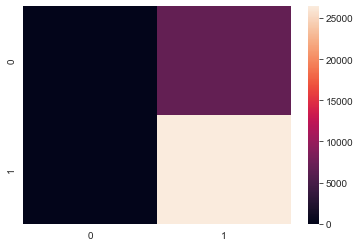

In [102]:
svm_pred = grid_result.predict(feat_test)

print('Train Accuracy : %.3f'%grid_search_svm.best_estimator_.score(feat_train, label_train))
print('Test Accuracy : %.3f'%grid_search_svm.best_estimator_.score(feat_test, label_test))
print('Best Accuracy Through Grid Search : %.3f' %grid_search_svm.best_score_)
print('Best Parameters : ', grid_search_svm.best_params_)
print()
print("Classification Report:\n", classification_report(label_test, svm_pred))
print("\n F1:\n", f1_score(label_test, svm_pred))
print("\n Precision score is:\n", precision_score(label_test, svm_pred))
print("\n Recall score is:\n", recall_score(label_test, svm_pred))
sn.heatmap(confusion_matrix(label_test, svm_pred))

#### Decision Tree

In [103]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(random_state=42)

# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [5, 10, 20,25],
    'min_samples_leaf': [10, 20, 50, 100,120],
    'criterion': ["gini", "entropy"]
}

grid_search_tree = GridSearchCV(estimator=decision_tree, 
                           param_grid=params, 
                           cv=cv, n_jobs=-1, verbose=1, scoring = "accuracy")

In [104]:
best_model = grid_search_tree.fit(feat_train, label_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


Train Accuracy : 0.799
Test Accuracy : 0.797
Best Accuracy Through Grid Search : 0.799
Best Parameters :  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 50}

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      6739
           1       0.80      1.00      0.89     26418

    accuracy                           0.80     33157
   macro avg       0.40      0.50      0.44     33157
weighted avg       0.63      0.80      0.71     33157


 F1:
 0.8868820814099875

 Precision score is:
 0.7967548330669241

 Recall score is:
 1.0


C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

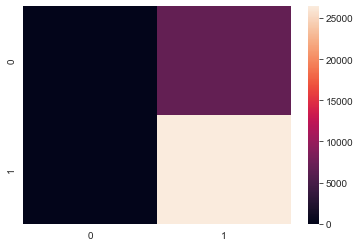

In [87]:
dt_pred=best_model.predict(feat_test)

print('Train Accuracy : %.3f'%grid_search_tree.best_estimator_.score(feat_train, label_train))
print('Test Accuracy : %.3f'%grid_search_tree.best_estimator_.score(feat_test, label_test))
print('Best Accuracy Through Grid Search : %.3f' %grid_search_tree.best_score_)
print('Best Parameters : ', grid_search_tree.best_params_)
print()
print("Classification Report:\n", classification_report(label_test, dt_pred))
print("\n F1:\n", f1_score(label_test, dt_pred))
print("\n Precision score is:\n", precision_score(label_test, dt_pred))
print("\n Recall score is:\n", recall_score(label_test, dt_pred))
sn.heatmap(confusion_matrix(label_test, dt_pred))

The following may be concluded:

1. All models bear similar statistics;
2. All models tested seem to have a f1 score of 0.89 for the proper detection of a patient going to be present at their appointment, but 0 for if they would be a no-show;
3. All models exibit high sensitivity (probability of true positive), but low specificity (probability of true negative).

While the three models may seem fairly accurate, more work is required in examining its capability in predicting no-shows as opposed to patients that show up to their appointments.

### ROC Analysis

This section will be for ROC evaluation. It remains however incomplete.

In [92]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# Compute ROC curve and ROC area for each class
n_classes = label.shape[0]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(label_test[:, i], grid_result[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(label_test.ravel(), grid_result.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

KeyError: 'key of type tuple not found and not a MultiIndex'